In [1]:
from google.colab import drive
import os
import gdown # Library to download files from Google Drive
!gdown 1MHlAH4gM539O26v9aUTLqUnKkwT1d51A # Google Drive ID of the zip file to be downloaded


Downloading...
From (original): https://drive.google.com/uc?id=1MHlAH4gM539O26v9aUTLqUnKkwT1d51A
From (redirected): https://drive.google.com/uc?id=1MHlAH4gM539O26v9aUTLqUnKkwT1d51A&confirm=t&uuid=598b2d18-e0b3-41b5-8926-d11aa9c5dae0
To: /content/images.zip
100% 348M/348M [00:06<00:00, 56.2MB/s]


In [2]:
!unzip -oq images # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

In [3]:

root_dir = '/content/images'


In [4]:
import gdown

# Define the Google Drive file ID for the responses.json file
file_id = '1UMZJl_B7Nwg3As33Cw9Pr9aHa-TszkW2'

# Define the output path for the downloaded file
output_path = '/content/ad_responses.json'

# Download the file using gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1UMZJl_B7Nwg3As33Cw9Pr9aHa-TszkW2
To: /content/ad_responses.json
100%|██████████| 31.1M/31.1M [00:00<00:00, 186MB/s]


'/content/ad_responses.json'

In [11]:
import json
import os
from PIL import Image
import numpy as np
import pickle

# Load the JSON data
responses_file = '/content/ad_responses.json'
with open(responses_file, 'r') as f:
    data = json.load(f)

# Create a dictionary to map '_id' to ad_info for faster lookup
ad_info_dict = {info['_id']: info for info in data.values() if '_id' in info}
# Define the root directory for images
images_dir = '/content/images'

# Define the target dimensions for resizing images (lower resolution for efficiency)
target_width = 512   # Lower resolution
target_height = 512  # Lower resolution

# Initialize lists to store calculated and extracted features
campaign_data = []

# Define the function to calculate age group percentages
def calculate_demographics(demographics):
    age_groups = {
        'age-13-17': 0,
        'age-18-24': 0,
        'age-25-34': 0,
        'age-35-44': 0,
        'age-45-54': 0,
        'age-55-64': 0,
        'age-65+': 0
    }
    gender_distribution = {
        'male': 0,
        'female': 0
    }
    unknown_gender_percentage = 0

    for demo in demographics:
        age = demo['age']
        gender = demo['gender']
        percentage = float(demo['percentage'])

        if gender == 'male':
            gender_distribution['male'] += percentage
        elif gender == 'female':
            gender_distribution['female'] += percentage
        else:
            unknown_gender_percentage += percentage

        # Calculate age group percentages
        if age == '18-24':
            age_groups['age-18-24'] += percentage
        elif age == '25-34':
            age_groups['age-25-34'] += percentage
        elif age == '35-44':
            age_groups['age-35-44'] += percentage
        elif age == '45-54':
            age_groups['age-45-54'] += percentage
        elif age == '55-64':
            age_groups['age-55-64'] += percentage
        elif age == '65+':
            age_groups['age-65+'] += percentage
        else:
            age_groups['age-13-17'] += percentage  # Assuming all other ages fall into this category

    # Distribute unknown gender percentage evenly between male and female
    total_known_percentage = gender_distribution['male'] + gender_distribution['female']
    if total_known_percentage < 1:
        unknown_gender_percentage /= 2
        gender_distribution['male'] += unknown_gender_percentage
        gender_distribution['female'] += unknown_gender_percentage

    return age_groups, gender_distribution

# Iterate through each image in the images directory
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):  # Check if the file is a JPEG image
        image_id = filename.split('.')[0]  # Extract ID from filename
        for key, value in ad_info_dict.items():
            if '_id' in value and value['_id'] == image_id:
                ad_info = value


                # Process only the necessary data to reduce memory load
                avg_spend = np.mean([int(ad_info.get("spend", {}).get("lower_bound", 0)), int(ad_info.get("spend", {}).get("upper_bound", 0))])
                avg_impressions = np.mean([int(ad_info.get("impressions", {}).get("lower_bound", 0)), int(ad_info.get("impressions", {}).get("upper_bound", 0))])
                cost_per_impression = avg_spend / avg_impressions if avg_impressions > 0 else float('inf')

                # Calculate age group percentages

                age_groups, gender_distribution = calculate_demographics(ad_info.get('demographic_distribution', []))


                # Append only necessary info to reduce memory footprint
                # Append only necessary info to reduce memory footprint
                campaign_data.append({
                    "ad_id": ad_info.get('_id', ''),
                    "cpi": cost_per_impression,
                    "age_groups": age_groups,
                    "gender_distribution": gender_distribution
                })

                break

# Save the normalized data
with open('/content/campaign_data.pkl', 'wb') as f:
    pickle.dump(campaign_data, f)

# Clear the large variables from memory
del campaign_data
del data


In [7]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, labels_cpi, labels_age_groups, image_directory, batch_size):
        self.image_filenames = image_filenames
        self.labels_cpi = labels_cpi
        self.labels_age_groups = labels_age_groups
        self.image_directory = image_directory
        self.batch_size = batch_size
        print(f"Received type for labels_cpi in __init__: {type(self.labels_cpi)}")
        print(f"Received type for labels_age_groups in __init__: {type(self.labels_age_groups)}")

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]


        print(f"Type of labels_cpi at __getitem__: {type(self.labels_cpi)}")
        print(f"Type of labels_age_groups at __getitem__: {type(self.labels_age_groups)}")

        batch_y_cpi = [self.labels_cpi.get(x, 0) for x in batch_x]  # Default to 0 if CPI label not found
        batch_y_age_groups = [self.labels_age_groups.get(x, [0]*7) for x in batch_x]  # Default to zeros list if age group label not found


        images = []
        for file_id in batch_x:
            file_path = os.path.join(self.image_directory, f'{file_id}.jpg')
            if os.path.exists(file_path):
                img = load_img(file_path, target_size=(512, 512), color_mode='rgb')  # Ensures loading in RGB
                img_array = img_to_array(img) / 255.0
                if img_array.shape != (512, 512, 3):
                    print(f"Debug: Image shape corrected from {img_array.shape} to (512, 512, 3)")
                images.append(img_array)
            else:
                print(f"Debug: File not found, using zero array for: {file_path}")
                images.append(np.zeros((512, 512, 3)))

        images = np.stack(images)
        batch_y_cpi = np.array(batch_y_cpi, dtype=np.float32).reshape(-1, 1)
        batch_y_age_groups = np.array([np.eye(7)[np.argmax(y)] for y in batch_y_age_groups])

        return images, [batch_y_cpi, batch_y_age_groups]

    def on_epoch_end(self):
        np.random.shuffle(self.image_filenames)

    def __data_generation(self, image_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, image_filename in enumerate(image_filenames_temp):
            # Store sample
            img = load_img(os.path.join(self.image_directory, image_filename + '.jpg'), target_size=self.dim)
            X[i,] = img_to_array(img) / 255.0

            # Store class
            y[i] = self.labels[image_filename]

        return X, y


In [12]:
import pickle

# Load the processed data from disk
with open('/content/campaign_data.pkl', 'rb') as f:
    campaign_data = pickle.load(f)

# Print the first few entries of the campaign data to verify
# Print the first few entries of the campaign data to verify
for campaign in campaign_data[:3]:  # Adjust the range as needed for more samples
    print("Ad ID:", campaign["ad_id"])
    print("Cost Per Impression (CPI):", campaign["cpi"])
    print("Age Group Percentages:")
    for age_group, percentage in campaign["age_groups"].items():
        print(f"{age_group}: {percentage:.2%}")

    print("\nGender Distribution:")
    for gender, percentage in campaign["gender_distribution"].items():
        print(f"{gender.capitalize()}: {percentage:.2%}")

    print("\n")


Ad ID: 223146421709995
Cost Per Impression (CPI): 0.01999849230537278
Age Group Percentages:
age-13-17: 0.00%
age-18-24: 0.83%
age-25-34: 1.20%
age-35-44: 2.45%
age-45-54: 8.97%
age-55-64: 32.11%
age-65+: 54.45%

Gender Distribution:
Male: 40.09%
Female: 59.91%


Ad ID: 992294637609039
Cost Per Impression (CPI): 0.019986933159108787
Age Group Percentages:
age-13-17: 0.00%
age-18-24: 25.03%
age-25-34: 22.49%
age-35-44: 11.60%
age-45-54: 10.94%
age-55-64: 14.51%
age-65+: 15.42%

Gender Distribution:
Male: 64.50%
Female: 35.50%


Ad ID: 268695227071280
Cost Per Impression (CPI): 0.011089135314118091
Age Group Percentages:
age-13-17: 0.00%
age-18-24: 0.97%
age-25-34: 3.38%
age-35-44: 8.81%
age-45-54: 18.03%
age-55-64: 33.05%
age-65+: 35.76%

Gender Distribution:
Male: 26.94%
Female: 73.06%




In [14]:
from sklearn.model_selection import train_test_split  # Add this import
# Load the processed data from disk
with open('/content/campaign_data.pkl', 'rb') as f:
    campaign_data = pickle.load(f)

# Extract features (image data) and labels (CPI, age distribution, and gender distribution)
images = []  # List to store image data
cpi_labels = []  # List to store CPI labels
age_labels = []  # List to store age distribution labels
gender_labels = []  # List to store gender distribution labels

for campaign in campaign_data:
    # Load image data and preprocess
    img = load_img('/content/images/' + campaign["ad_id"] + '.jpg', target_size=(216, 216), color_mode='rgb')
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    images.append(img_array)

    # Extract CPI label
    cpi_labels.append(campaign["cpi"])

    # Extract age distribution labels and convert from dictionary to list
    age_distribution = [
        campaign["age_groups"].get("age-13-17", 0.0),
        campaign["age_groups"].get("age-18-24", 0.0),
        campaign["age_groups"].get("age-25-34", 0.0),
        campaign["age_groups"].get("age-35-44", 0.0),
        campaign["age_groups"].get("age-45-54", 0.0),
        campaign["age_groups"].get("age-55-64", 0.0),
        campaign["age_groups"].get("age-65+", 0.0)
    ]
    age_labels.append(age_distribution)

    # Extract gender distribution labels
    gender_distribution = [
        campaign["gender_distribution"].get("male", 0.0),
        campaign["gender_distribution"].get("female", 0.0)
    ]
    gender_labels.append(gender_distribution)

# Convert lists to numpy arrays
images = np.array(images)
cpi_labels = np.array(cpi_labels)
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)

# Split the dataset into training and testing sets
images_train, images_test, cpi_train, cpi_test, age_train, age_test, gender_train, gender_test = train_test_split(
    images, cpi_labels, age_labels, gender_labels, test_size=0.2, random_state=42)

# Print shapes to verify
print("Images Train Shape:", images_train.shape)
print("CPI Labels Train Shape:", cpi_train.shape)
print("Age Labels Train Shape:", age_train.shape)
print("Gender Labels Train Shape:", gender_train.shape)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Images Train Shape: (1468, 216, 216, 3)
CPI Labels Train Shape: (1468,)
Age Labels Train Shape: (1468, 7)
Gender Labels Train Shape: (1468, 2)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Define the input layer
input_layer = Input(shape=(216, 216, 3))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Branch for CPI prediction
cpi_hidden = Dense(128, activation='relu')(x)
cpi_output = Dense(1, activation='linear', name='cpi_output')(cpi_hidden)

# Branch for age distribution prediction
age_hidden = Dense(128, activation='relu')(x)
age_output = Dense(7, activation='softmax', name='age_output')(age_hidden)

# Branch for gender prediction
gender_hidden = Dense(128, activation='relu')(x)
gender_output = Dense(2, activation='softmax', name='gender_output')(gender_hidden)

# Combine all branches into a single model
combined_model = Model(inputs=input_layer, outputs=[cpi_output, age_output, gender_output])

# Compile the model with appropriate loss functions and metrics
combined_model.compile(
    optimizer='adam',
    loss={'cpi_output': 'mean_squared_error', 'age_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
    metrics={'cpi_output': 'mean_absolute_error', 'age_output': 'accuracy', 'gender_output': 'accuracy'}
)

# Print model summary
combined_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 216, 216, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 214, 214, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 107, 107, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 105, 105, 64)         18496     ['max_pooling2d[0][0]']   

In [16]:
# Train the model
history = combined_model.fit(images_train, {'cpi_output': cpi_train, 'age_output': age_train, 'gender_output': gender_train},
                             epochs=10, batch_size=10, validation_split=0.2)

# Evaluate the model on test data
eval_results = combined_model.evaluate(images_test, {'cpi_output': cpi_test, 'age_output': age_test, 'gender_output': gender_test})

# Print evaluation results
print("Evaluation Results:")
print("CPI - Mean Absolute Error:", eval_results[3])
print("Age Distribution - Loss:", eval_results[4])
print("Gender - Accuracy:", eval_results[5])


Epoch 1/10
118/118 [==============================] - 203s 2s/step - loss: 22.8131 - cpi_output_loss: 19.6886 - age_output_loss: 2.1719 - gender_output_loss: 0.9526 - cpi_output_mean_absolute_error: 0.7036 - age_output_accuracy: 0.2581 - gender_output_accuracy: 0.6840 - val_loss: 2.4457 - val_cpi_output_loss: 0.0011 - val_age_output_loss: 1.7588 - val_gender_output_loss: 0.6857 - val_cpi_output_mean_absolute_error: 0.0245 - val_age_output_accuracy: 0.3776 - val_gender_output_accuracy: 0.6769
Epoch 2/10
118/118 [==============================] - 220s 2s/step - loss: 2.4236 - cpi_output_loss: 0.0029 - age_output_loss: 1.7495 - gender_output_loss: 0.6711 - cpi_output_mean_absolute_error: 0.0328 - age_output_accuracy: 0.3186 - gender_output_accuracy: 0.7351 - val_loss: 2.4364 - val_cpi_output_loss: 0.0021 - val_age_output_loss: 1.7504 - val_gender_output_loss: 0.6840 - val_cpi_output_mean_absolute_error: 0.0345 - val_age_output_accuracy: 0.3810 - val_gender_output_accuracy: 0.6803
Epoch 3/

1/1 [==============================] - 0s 75ms/step
Predicted CPI: 0.061491966
Predicted Age Distributions:
age-13-17: 0.00
age-18-24: 0.06
age-25-34: 0.24
age-35-44: 0.14
age-45-54: 0.18
age-55-64: 0.15
age-65+: 0.24
Predicted Male Rate: 0.51
Predicted Female Rate: 0.49


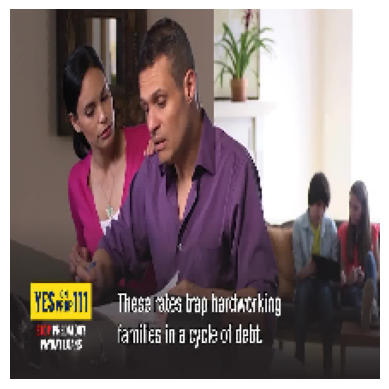

In [37]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Select a random image from /content/images directory
image_files = os.listdir('/content/images')
random_image_file = random.choice(image_files)
image_path = os.path.join('/content/images', random_image_file)

# Load and preprocess the image
img = load_img(image_path, target_size=(216, 216), color_mode='rgb')
img_array = img_to_array(img) / 255.0
input_image = np.expand_dims(img_array, axis=0)

# Predict CPI, age distribution, and gender distribution
cpi_pred, age_pred, gender_pred = combined_model.predict(input_image)
print("Predicted CPI:", cpi_pred[0][0])

# Print all age distributions
age_groups = ['age-13-17', 'age-18-24', 'age-25-34', 'age-35-44', 'age-45-54', 'age-55-64', 'age-65+']
print("Predicted Age Distributions:")
for i, age_group_prob in enumerate(age_pred[0]):
    age_group = age_groups[i]
    print(f"{age_group}: {age_group_prob:.2f}")

# Print gender prediction
gender_labels = ['male', 'female']
predicted_gender_probs = gender_pred[0]
for gender, prob in zip(gender_labels, predicted_gender_probs):
    print(f"Predicted {gender.capitalize()} Rate: {prob:.2f}")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 75ms/step
Predicted CPI: 0.15989232
Predicted Age Distributions:
age-13-17: 0.00
age-18-24: 0.09
age-25-34: 0.53
age-35-44: 0.14
age-45-54: 0.13
age-55-64: 0.06
age-65+: 0.06
Predicted Male Rate: 0.69
Predicted Female Rate: 0.31


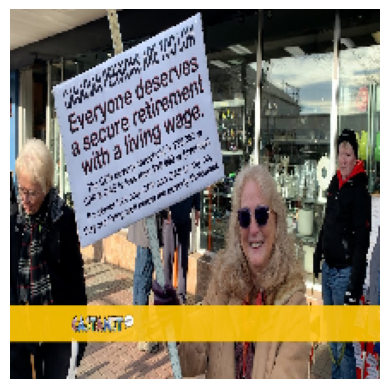

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Specify the path to the image
image_path = "/content/maxresdefault.jpg"

# Load and preprocess the image
img = load_img(image_path, target_size=(216, 216), color_mode='rgb')
img_array = img_to_array(img) / 255.0
input_image = np.expand_dims(img_array, axis=0)

# Predict CPI, age distribution, and gender distribution
cpi_pred, age_pred, gender_pred = combined_model.predict(input_image)
print("Predicted CPI:", cpi_pred[0][0])

# Print all age distributions
age_groups = ['age-13-17', 'age-18-24', 'age-25-34', 'age-35-44', 'age-45-54', 'age-55-64', 'age-65+']
print("Predicted Age Distributions:")
for i, age_group_prob in enumerate(age_pred[0]):
    age_group = age_groups[i]
    print(f"{age_group}: {age_group_prob:.2f}")

# Print gender prediction
gender_labels = ['male', 'female']
predicted_gender_probs = gender_pred[0]
for gender, prob in zip(gender_labels, predicted_gender_probs):
    print(f"Predicted {gender.capitalize()} Rate: {prob:.2f}")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


In [29]:
from lifelines.utils import concordance_index

# Extract the predicted CPI values from the model
predicted_cpi = combined_model.predict(images_test)[0].flatten()

# Calculate the concordance index
c_index = concordance_index(cpi_test, -predicted_cpi)  # Negative sign because lifelines uses higher values for better outcomes

print("Concordance Index for CPI:", c_index)


12/12 [==============================] - 9s 786ms/step
Concordance Index for CPI: 0.524118086696562


In [24]:
from google.colab import drive
import shutil
# Mount Google Drive
shutil.rmtree('/content/drive', ignore_errors=True)
drive.mount('/content/drive')
# Save the model to Google Drive
combined_model.save('/content/drive/MyDrive/path/to/save/modelAgeGender.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
